##Import e style

In [126]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from glob import glob
import shutil
from collections import defaultdict
import os
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

#Formattazione grafica
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
#####

RANDOM_SEED = 42   #Replicare l'esperimento
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()#Rende visibili le modifiche

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cuda')

## Importa dataser



In [127]:
!rm -rf GTSRB
!rm -rf data
!rm -rd GTSRB_Final_Training_Images.zip

In [128]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip


--2022-07-12 22:25:53--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  24.3MB/s    in 12s     

2022-07-12 22:26:06 (21.6 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration 


In [129]:
#train_folders = sorted(glob('GTSRB/Final_Training/Images/*')) #glob restituisce i path che corrispondono
train_folders = (glob('GTSRB/Final_Training/Images/*'))
print("Classi:")
len(train_folders)

Classi:


43


CSV funzioni visualizzazione immagini

In [130]:
#Carica immagine
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)    #conversione BGR a RBG 

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

#Mostra immagine
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_image2(img):
    img = PIL.Image.open(img)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title(f'size: {img.size}')
    ax[0].imshow(img)

#Mostra griglia di immagini
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Sample per ogni classe

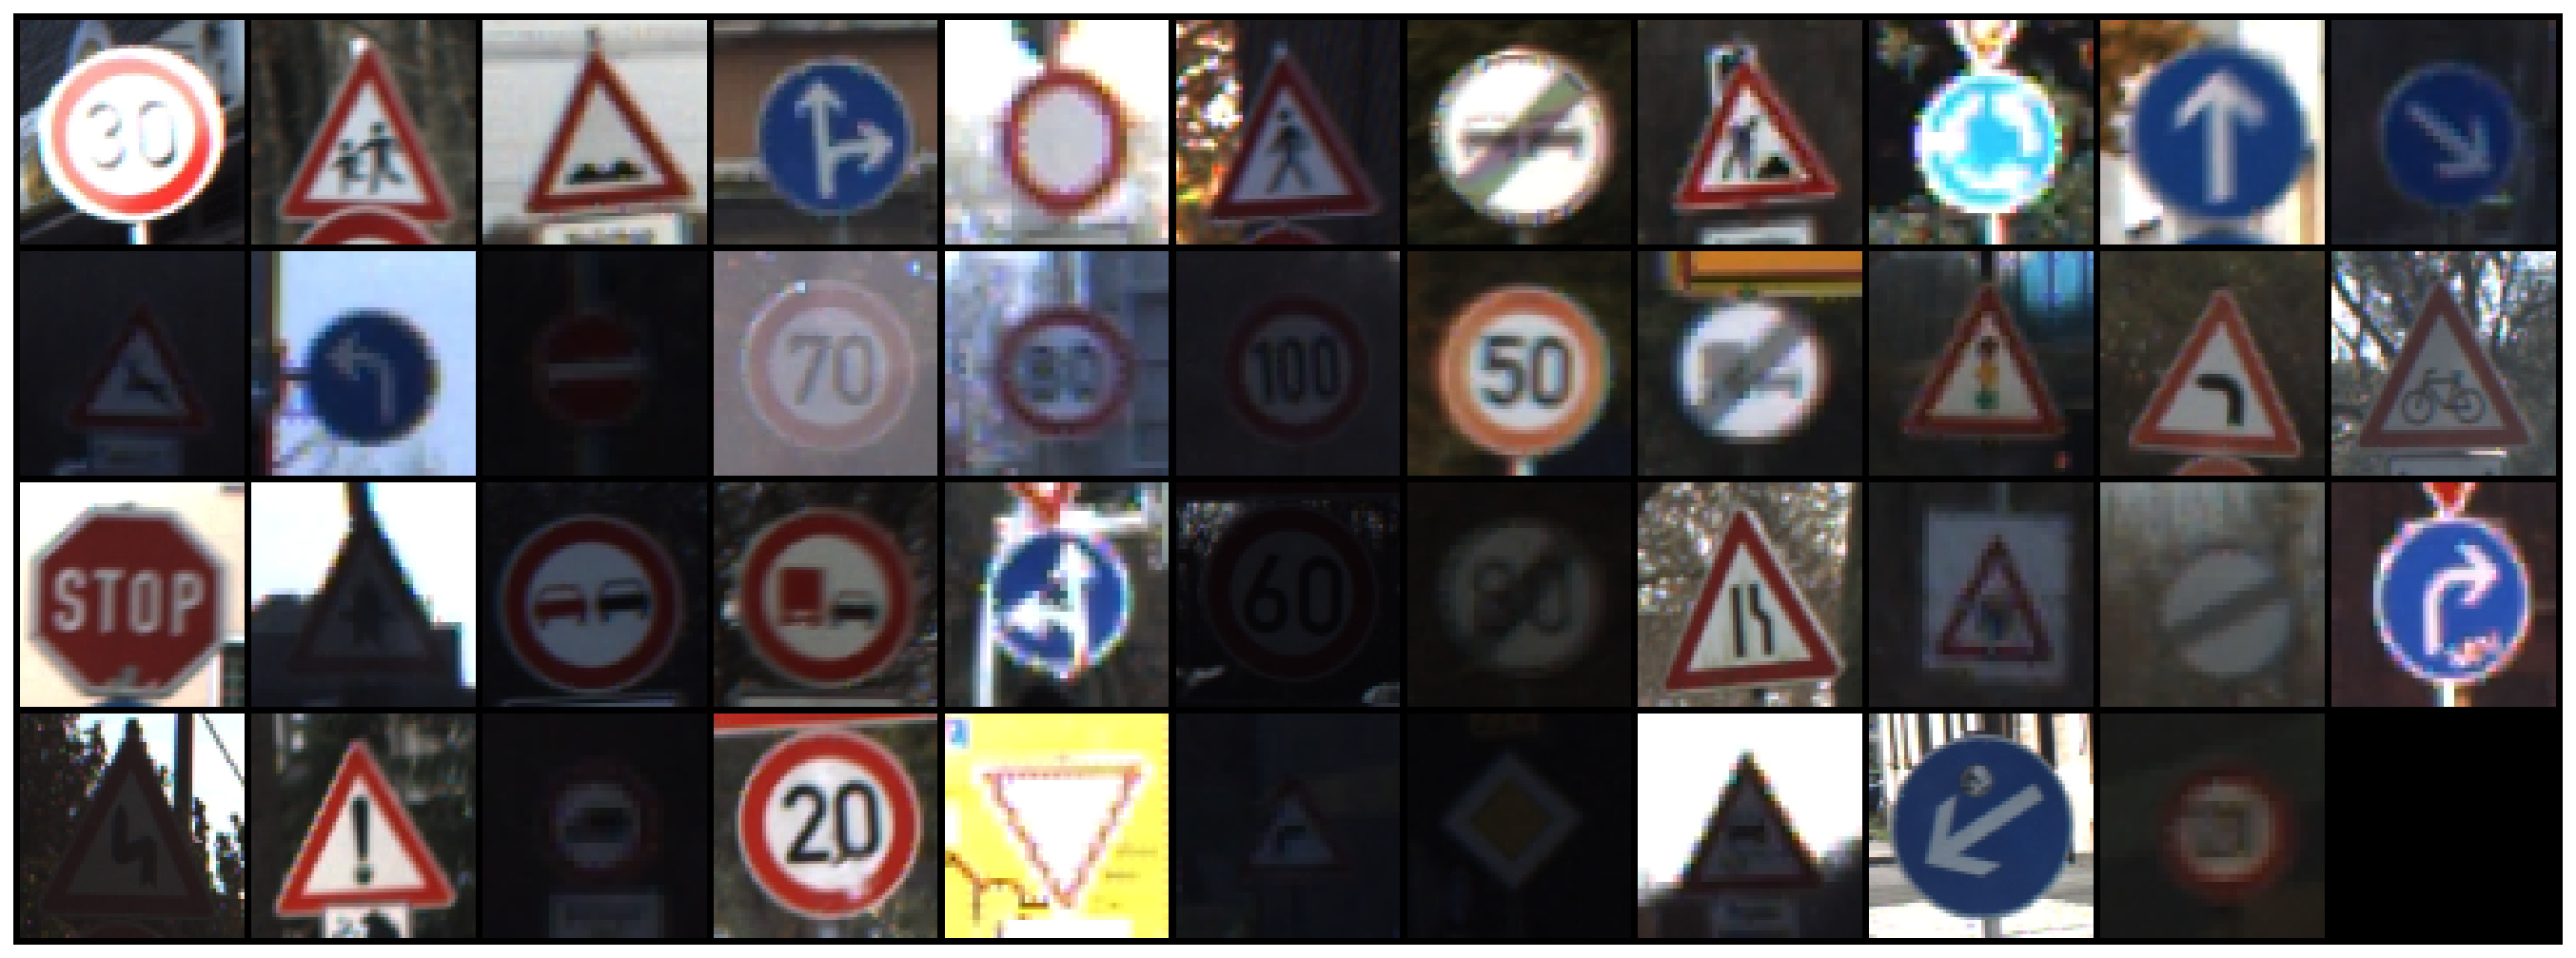

In [131]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]   #np.random.choice restituisce un elemento random dell'array
show_sign_grid(sample_images)                                                    #con f'{x}/*ppm' la stringa viene calcolara a runtime 

Singola immagine

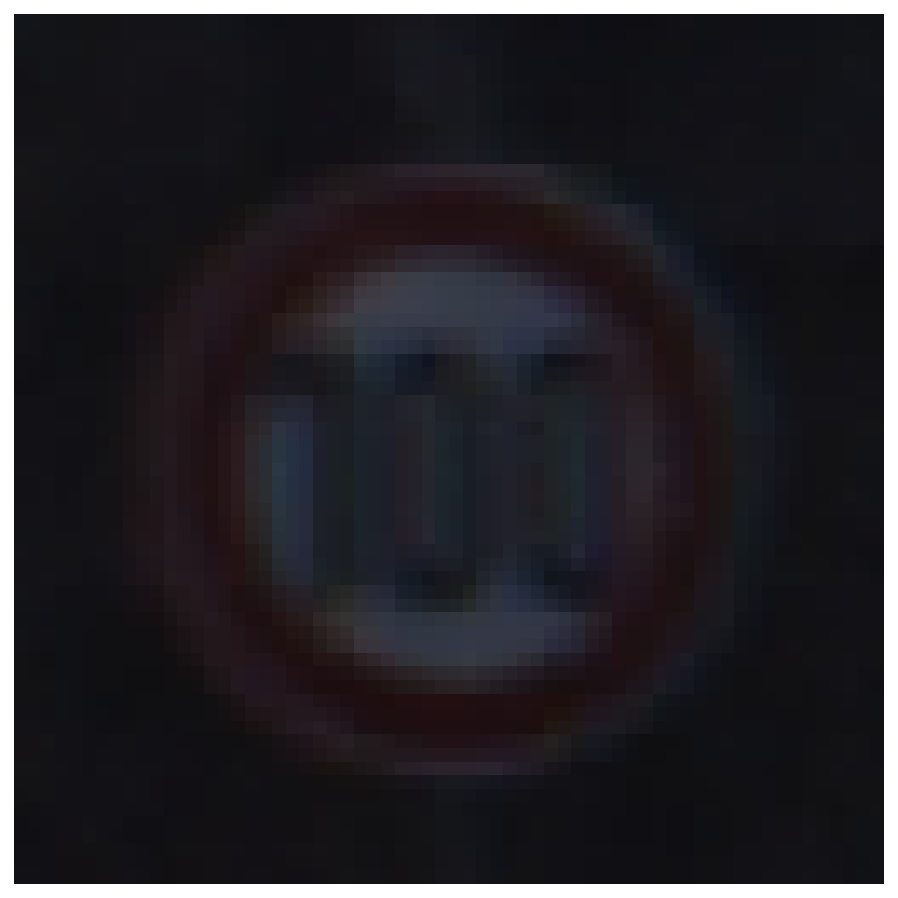

In [132]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building dataset


In [133]:
'''class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [13, 14, 15, 18]


class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 
    'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 
    'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
    'Speed limit (120km/h)', 'No passing', 
    'No passing for vehicles over 3.5 metric tons', 
    'Right-of-way at the next intersection', 'Priority road', 'Yield (give_way)', 
    'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 
    'No entry', 'General caution', 'Dangerous curve to the left', 
    'Dangerous curve to the right', 'Double curve', 'Bumpy road', 
    'Slippery road', 'Road narrows on the right', 'Road work', 
    'Traffic signals', 'Pedestrians', 'Children crossing', 
    'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 
    'End of all speed and passing limits', 'Turn right ahead', 
    'Turn left ahead', 'Ahead only', 'Go straight or right', 
    'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 
    'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']
    '''

class_names = ['00_Speed limit (20km/h)', '01_Speed limit (30km/h)', '02_Speed limit (50km/h)', 
    '03_Speed limit (60km/h)', '04_Speed limit (70km/h)', '05_Speed limit (80km/h)', 
    '06_End of speed limit (80km/h)', '07_Speed limit (100km/h)', 
    '08_Speed limit (120km/h)', '09_No passing', 
    '10_No passing for vehicles over 3.5 metric tons', 
    '11_Right-of-way at the next intersection', '12_Priority road', '13_Yield (give_way)', 
    '14_Stop', '15_No vehicles', '16_Vehicles over 3.5 metric tons prohibited', 
    '17_No entry', '18_General caution', '19_Dangerous curve to the left', 
    '20_Dangerous curve to the right', '21_Double curve', '22_Bumpy road', 
    '23_Slippery road', '24_Road narrows on the right', '24_Road work', 
    '26_Traffic signals', '27_Pedestrians', '28_Children crossing', 
    '29_Bicycles crossing', '30_Beware of ice/snow', '31_Wild animals crossing', 
    '32_End of all speed and passing limits', '33_Turn right ahead', 
    '34_Turn left ahead', '35_Ahead only', '36_Go straight or right', 
    '37_Go straight or left', '38_Keep right', '39_Keep left', '40_Roundabout mandatory', 
    '41_End of no passing', '42_End of no passing by vehicles over 3.5 metric tons']

class_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                 41, 42]


copia immagini nelle directory per ogni classe (semplifica torchvision's dataset helper)

In [134]:
!rm -rf data

DATA_DIR = Path('data')

#DATASETS = ['train', 'val', 'test']
DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

**90% training, 10% validation per ogni classe** (Nella corrispettiva cartella)

In [135]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    #image_paths, indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    image_paths, indices_or_sections=[int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')   # Copy the content of source to destination

00_Speed limit (20km/h): 2220
01_Speed limit (30km/h): 540
02_Speed limit (50km/h): 390
03_Speed limit (60km/h): 390
04_Speed limit (70km/h): 630
05_Speed limit (80km/h): 240
06_End of speed limit (80km/h): 240
07_Speed limit (100km/h): 1500
08_Speed limit (120km/h): 360
09_No passing: 1200
10_No passing for vehicles over 3.5 metric tons: 2070
11_Right-of-way at the next intersection: 780
12_Priority road: 420
13_Yield (give_way): 1110
14_Stop: 1980
15_No vehicles: 1860
16_Vehicles over 3.5 metric tons prohibited: 1440
17_No entry: 2250
18_General caution: 240
19_Dangerous curve to the left: 600
20_Dangerous curve to the right: 210
21_Double curve: 270
22_Bumpy road: 780
23_Slippery road: 1320
24_Road narrows on the right: 1470
24_Road work: 2010
26_Traffic signals: 210
27_Pedestrians: 1410
28_Children crossing: 420
29_Bicycles crossing: 270
30_Beware of ice/snow: 450
31_Wild animals crossing: 240
32_End of all speed and passing limits: 689
33_Turn right ahead: 330
34_Turn left ahead: 

##Il dataset è sbilanciato, applico trasformazioni per **"Augmentation"**

In [136]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomAffine(degrees=(-20, 20), translate=(0.1,0.3), scale=(0.6,1), shear=(-20, 20)),
  #T.RandomErasing(), #cancella autonomamente parti dell'immagine
  #AddGaussianNoise(0.1, 0.08),  #rumore gaussiano (vero e proprio "rumore del sensore", disturbo)
  T.ColorJitter(brightness=0.7, contrast=0.3, saturation=0.4, hue=0), #modifica condizioni foto
  T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), #blur
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)

]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Creo dataset PyTorch per ogni "image dataset folder" e "data loaders" per poter caricare il dataset di grandi dimensioni un "batch alla volta"


In [137]:

image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}
'''
BATCH = 64
WORKERS = 4
train_loader = DataLoader(
  'data/train', batch_size=BATCH, 
  shuffle=True, num_workers=WORKERS
  )
valid_loader = DataLoader(
  'data/val', batch_size=BATCH, 
  shuffle=False, num_workers=WORKERS
  )
test_loader = DataLoader(
  'data/test', batch_size=1, 
  shuffle=True, num_workers=1
  )'''

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


"\nBATCH = 64\nWORKERS = 4\ntrain_loader = DataLoader(\n  'data/train', batch_size=BATCH, \n  shuffle=True, num_workers=WORKERS\n  )\nvalid_loader = DataLoader(\n  'data/val', batch_size=BATCH, \n  shuffle=False, num_workers=WORKERS\n  )\ntest_loader = DataLoader(\n  'data/test', batch_size=1, \n  shuffle=True, num_workers=1\n  )"


Salvo numero di example e nome delle classi in ogni dataset

In [138]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes


dataset_sizes

{'train': 35288, 'val': 3921}



Visualizza immagini dopo trasformazioni (reverse della normalizzazione e dei canali colore)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


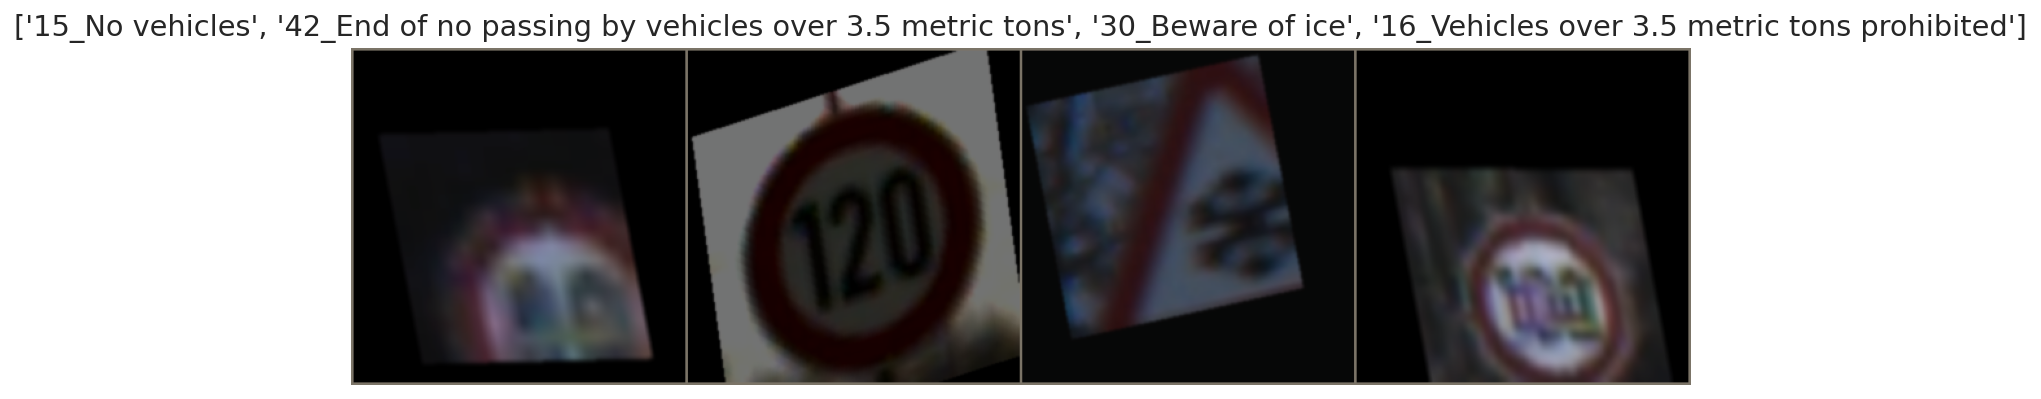

In [139]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creo Modello
(Più modelli in base all'input per confronto)

Il layer di output deve essere sostituito per combaciare con il numero di output ed essere addestrato

In [140]:
def create_model(net_model, n_classes):

  if(net_model=='resnet18_no'):
    model = models.resnet18(pretrained = False, progress = True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='resnet18'):
    model = models.resnet18(pretrained = True, progress = True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)  

  if (net_model == 'alexnet'):
    model = models.alexnet(pretrained = True, progress = True)
    n_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(n_features,n_classes)

  if(net_model == 'googleLeNet'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='mobilenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, n_classes)

  if(net_model=='mobilenet_v3'):
    model = models.mobilenet_v3_small(pretrained=True, progress=True)
    model.classifier[-1] = nn.Linear(1024, n_classes)

  if(net_model == 'shufflenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
    model.fc = nn.Linear(1024, n_classes)

  if(net_model == 'efficientnet_b0'):
    model = models.efficientnet_b0(pretrained=True, progress=True)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes)

#  if(net_model == 'NASNet-A-Mobile'):
#    #model = timm.create_model('nasnetalarge', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
#    #nasnetamobile(num_classes=1000, pretrained='imagenet')
#    model = models.nasnetmobile(pretrained = True, progress=True)


    #model = models.mobilenet_v3_small(pretrained=True, progress=True)
    #print(model.classifier) 

  return model.to(device)

### Training
Modello in train-mode. Si cicla sugli input e le lora label, si ottiene la predizione (classe con max prob) e si calcola loss ed accuracy

In [141]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  
  #Calcolo gradiente attivo
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()
  accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)

##Evaluating
Simile al training ma effettuato sul validation per verificare il modello e non calcola gradiente

In [142]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  #Calcolo gradiente inattivo
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)


##Training completo

L'History salva le performance, pytorch salva il "miglior modello" ed i suoi pesi ottenuti durante il training

In [143]:
                                                                    #10 probabilmente 15
def train_model(model,net, data_loaders, dataset_sizes, device, n_epochs=3):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  PATH = 'drive/MyDrive/Modelli'
  if(net=='resnet18:no'):
    PATH = 'drive/MyDrive/Modelli/resnet18_no/resnet18_no_pretrain_no_augmentation.pt'  

  if(net=='resnet18'):
    PATH = 'drive/MyDrive/Modelli/resnet18/resnet18.pt'

  if (net == 'alexnet'):
    PATH = 'drive/MyDrive/Modelli/alexnet/alexnet.pt'

  if(net == 'googleLeNet'):
    PATH = 'drive/MyDrive/Modelli/googleLeNet/googleLeNet.pt'

  if(net=='mobilenet_v2'):
    PATH = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v2.pt'

  if(net=='mobilenet_v3'):
    PATH = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v3.pt'

  if(net == 'shufflenet_v2'):
    PATH = 'drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2.pt'

  if(net == 'efficientnet_b0'):
    PATH = 'drive/MyDrive/Modelli/efficientnet_b0/efficientnet_b0.pt'

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss}  accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss}  accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      #Salvataggio
      #torch.save(model.state_dict(), 'drive/MyDrive/Modelli/resnet18/resnet18_no_pretrain_no_augmentation.bin')
      torch.save(model.state_dict(), PATH)
      
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  torch.save(model.state_dict(), PATH)
  print("Model saved")

  
  return model, history

##ResNet18 no pretrain no augmentation

In [ ]:
%%time

base_model = create_model("resnet18_no",len(class_names))

base_model, history = train_model(base_model, 'resnet18_no', data_loaders, dataset_sizes, device)


Scelta e training del modello:

##ResNet18

In [ ]:
base_model = create_model("resnet18",len(class_names))

#comando time restituisce wall time della cella

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
%%time

base_model, history = train_model(base_model, 'resnet18', data_loaders, dataset_sizes, device)

##AlexNet

In [ ]:
%%time
base_model = create_model('alexnet', len(class_names))


base_model, history = train_model(base_model, 'alexnet', data_loaders, dataset_sizes, device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 2.208136021657175  accuracy 0.375553926100679
Val   loss 0.7629202907649568  accuracy 0.7620504973221117

Epoch 2/10
----------
Train loss 1.387567051396071  accuracy 0.605700258233175
Val   loss 0.20829312473896816  accuracy 0.9428717163988778

Epoch 3/10
----------
Train loss 1.1775299816576472  accuracy 0.6742117512034941
Val   loss 0.16321383002432827  accuracy 0.9500127518490181

Epoch 4/10
----------
Train loss 0.6909717350560717  accuracy 0.799151975005579
Val   loss 0.029980961068045035  accuracy 0.9910737056873247

Epoch 5/10
----------
Train loss 0.582535937098535  accuracy 0.8263142793381578
Val   loss 0.022097255314745348  accuracy 0.9928589645498597

Epoch 6/10
----------
Train loss 0.5418174464570424  accuracy 0.8386839672267031
Val   loss 0.019544663650156363  accuracy 0.993369038510584

Epoch 7/10
----------


##GoogleLeNet

In [ ]:
%%time
base_model = create_model('googleLeNet', len(class_names))


base_model, history = train_model(base_model, 'googleLeNet', data_loaders, dataset_sizes, device)

Epoch 1/3
----------


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLo

Train loss 1.279044441136836  accuracy 0.6530832010881886
Val   loss 0.0382327733044166  accuracy 0.990053557765876

Epoch 2/3
----------
Train loss 0.5386430099010318  accuracy 0.8543980956699161
Val   loss 0.017752902024852708  accuracy 0.9956643713338433

Epoch 3/3
----------


##MobileNet_v2

In [ ]:
%%time
base_model = create_model('mobilenet_v2', len(class_names))


base_model, history = train_model(base_model, 'mobilenet_v2', data_loaders, dataset_sizes, device)

##MobileNet_v3

In [ ]:
%%time
base_model = create_model('mobilenet_v3', len(class_names))

base_model, history = train_model(base_model, 'mobilenet_v3' , data_loaders, dataset_sizes, device)

##ShuffleNet_v2

In [ ]:
%%time
base_model = create_model('shufflenet_v2', len(class_names))


base_model, history = train_model(base_model, 'shufflenet_v2', data_loaders, dataset_sizes, device)

##EfficientNet_b0

In [ ]:
%%time
base_model = create_model('efficientnet_b0', len(class_names))

base_model, history = train_model(base_model, 'efficientnet_b0', data_loaders, dataset_sizes, device)

##Visualizzazione History

In [55]:
def plot_training_history(history):
  #device = torch.device("cpu")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], 'o-', label='train loss')
  ax1.plot(history['val_loss'], '^-', label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 3.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], 'o-', label='train accuracy')
  #print("Sono qui")
  ax2.plot(history['val_acc'], '^-', label='validation accuracy')
  
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')
  fig.savefig('drive/MyDrive/Modelli/alexnet/alexnet.png')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

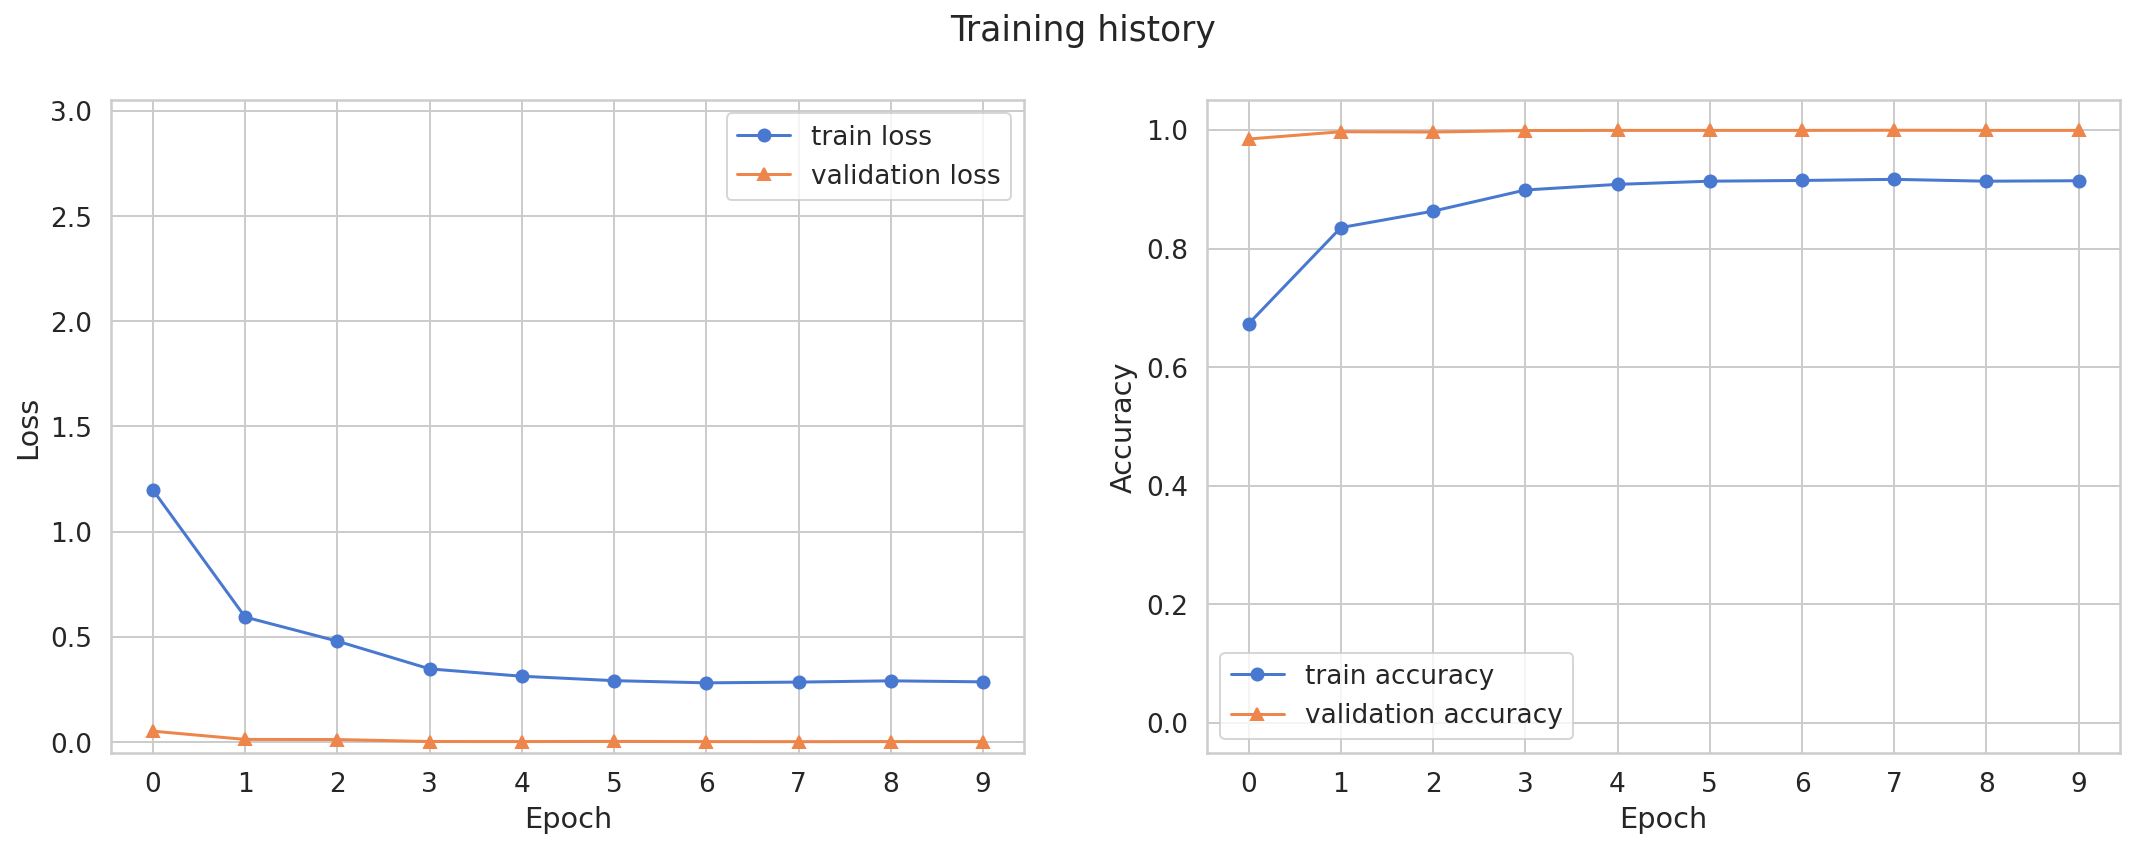

In [ ]:
plot_training_history(history)


### Evaluation

Valutazione del modello sul TestSet. (No calcolo gradiente)

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [25]:
base_model = create_model('resnet18', 43)
#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18_no_pretrain_no_augmentation.pt',map_location=torch.device('cpu')))
base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18.pt', map_location = device ))

#base_model = create_model('alexnet', 43)
#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/alexnet/alexnet.pt', map_location = device))      

show_predictions(base_model, class_names, n_images=8)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

NameError: ignored

In [20]:
def get_predictions(model, data_loader):
  frame_count = 0 # To count total frames.
  total_fps = 0 # To get the final frames per second.

  model = model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      start_time = time.time() #time
      outputs = model(inputs)
      end_time = time.time()

      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      ground_truth.extend(labels)

      fps = 1 / (end_time - start_time)
  
      total_fps += fps
      
      frame_count += 1

  predictions = torch.as_tensor(predictions).cpu()
  ground_truth = torch.as_tensor(ground_truth).cpu()
  avg_fps = total_fps / frame_count
  return predictions, ground_truth, avg_fps

In [ ]:
y_pred, y_test , FPS = get_predictions(base_model, data_loaders['test'])
print(y_pred, y_test)
print('Avg FPS:',FPS)

KeyError: ignored

In [21]:
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:",accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print()
'''def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

print("Accuracy: .3f", )
from sklearn.metrics import accuracy_score
print('Test accuracy: ',accuracy_score(labels, classes_x)*100)'''

NameError: ignored

##Confusion Matrix
Visualizzazione più significativa rispetto all'accuracy delle performance 

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  #plt.figure(figsize = (10,7))
  #plt.figure(figsize=(60, 40), dpi=90)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues", annot_kws={'fontsize':5})
  #hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');
  

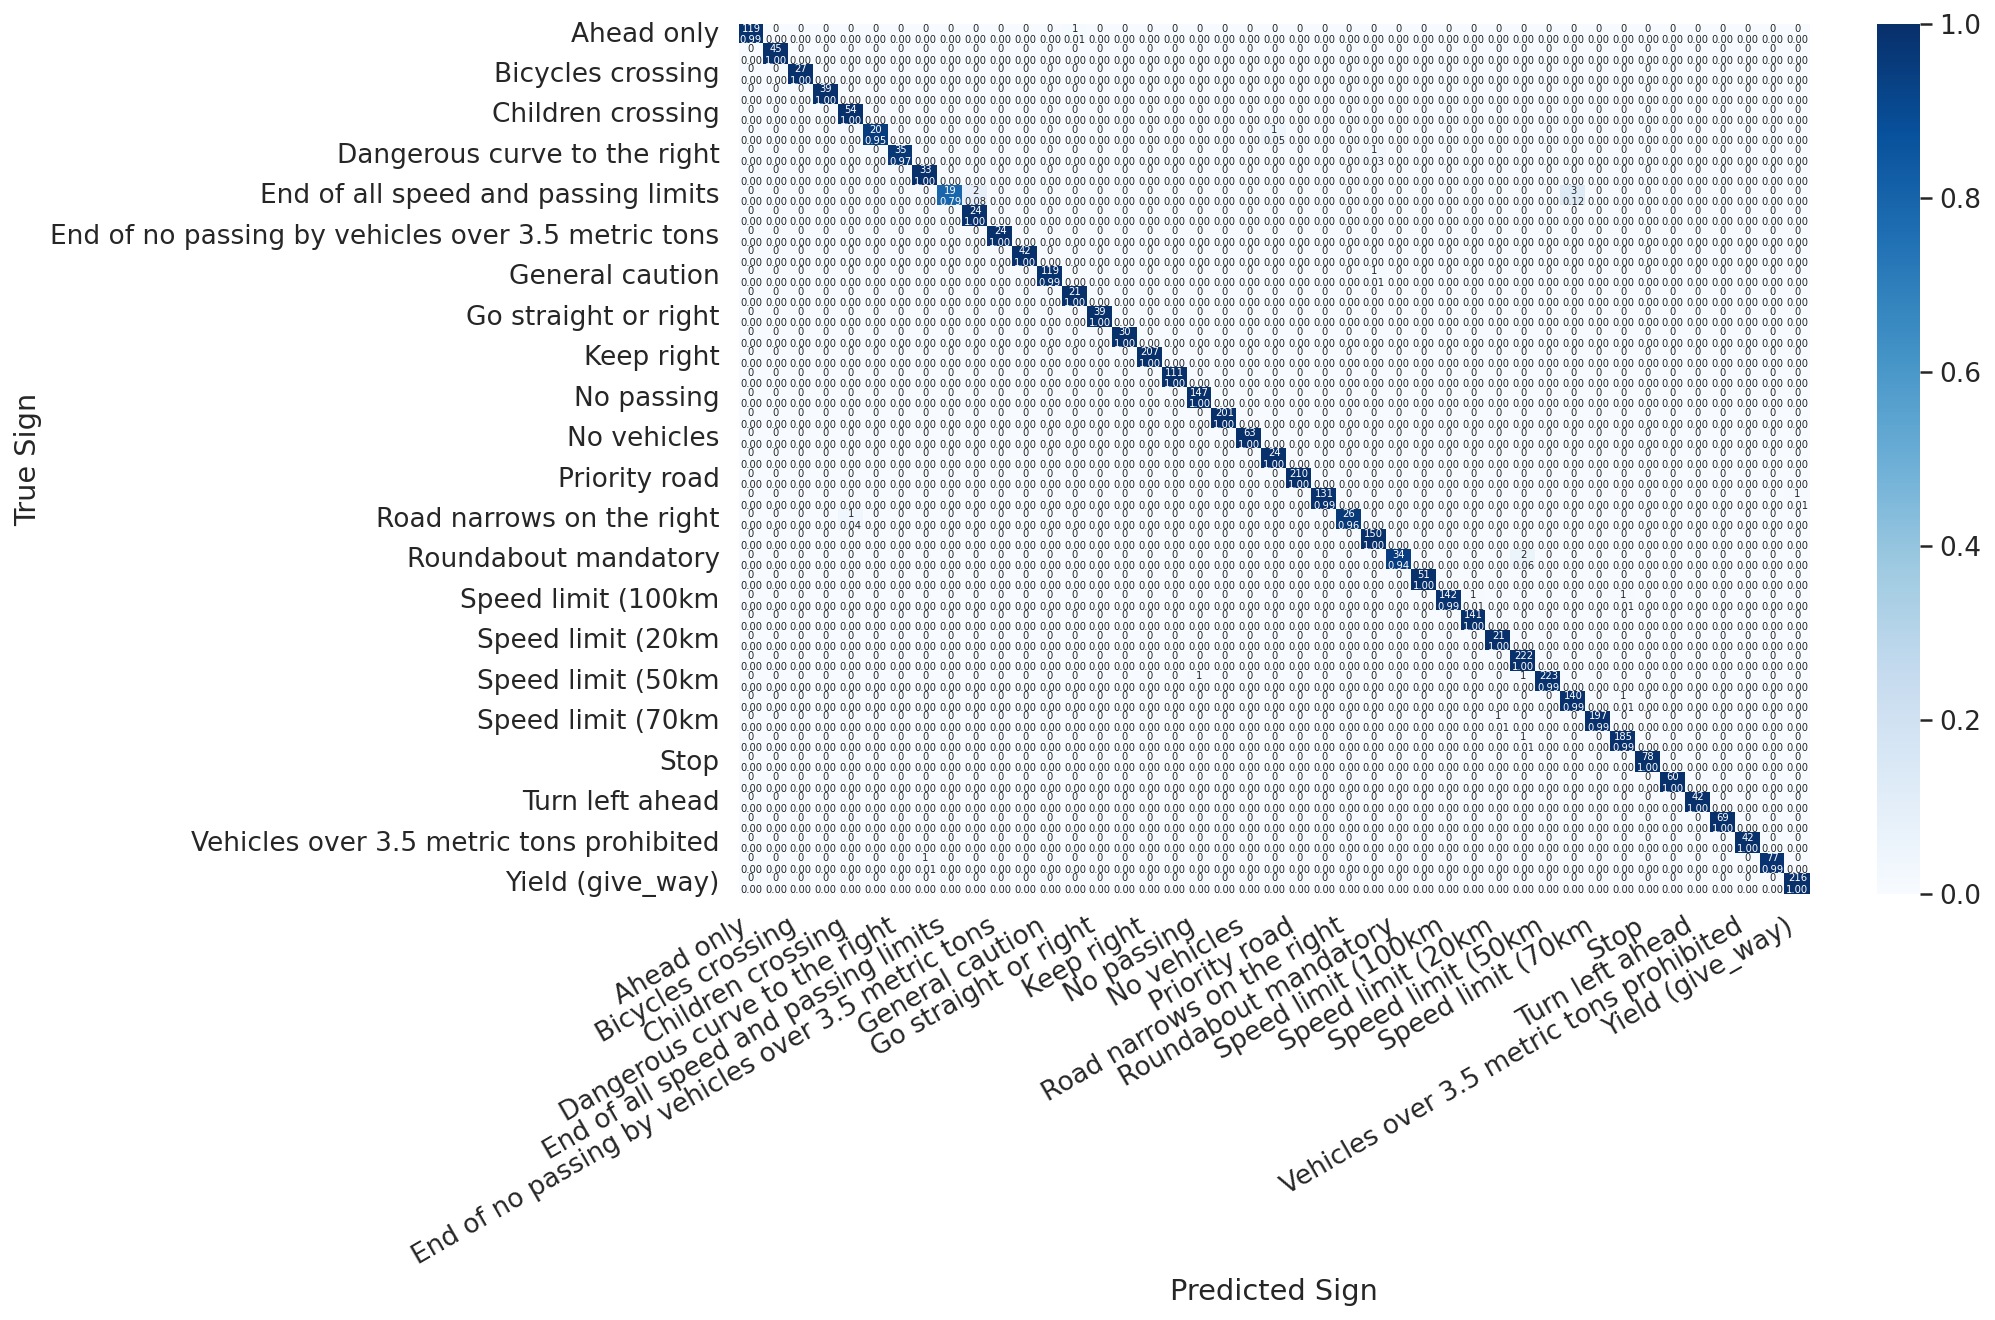

In [ ]:
cm = confusion_matrix(y_test, y_pred)

show_confusion_matrix(cm, class_names)

## Classificazione immagine non vista


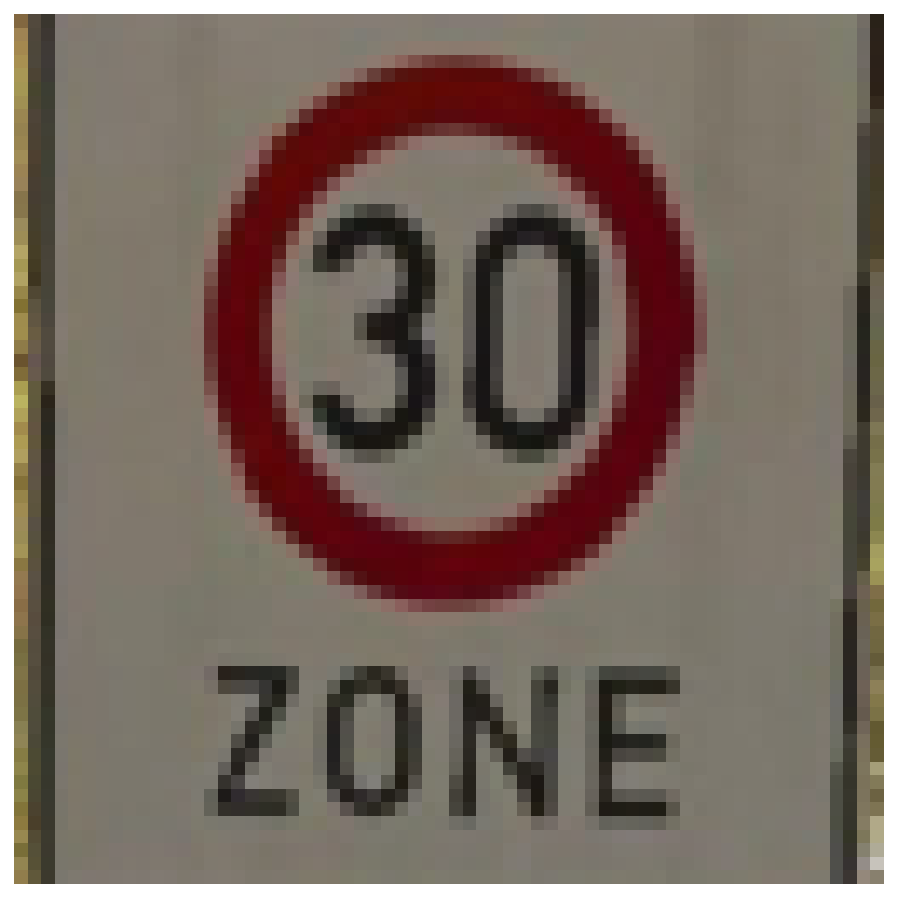

In [ ]:
#!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
#!gdown https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSrE6qyU5oAorfk_ABkjTcqtLXrwqUI3pxfhK5TeOP0cJqGa9mECMhx39vXxqjKtxhcVh0&usqp=CAU
#show_image('stop-sign.jpg')


#show_image('/content/images?q=tbn:ANd9GcSrE6qyU5oAorfk_ABkjTcqtLXrwqUI3pxfhK5TeOP0cJqGa9mECMhx39vXxqjKtxhcVh0')

show_image('drive/MyDrive/inference/IMG_20220710_195852_099.jpg')

Test Trasformazioni

In [ ]:
import PIL.Image
import matplotlib.pyplot as plt
#show_image('stop-sign.jpg')

#tran = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75), shear=(-10, 10))
tran = T.Compose([ T.RandomAffine(degrees=(-30, 30), translate=(0.1,0.3), scale=(0.6,1), shear=(-20, 20)),
T.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0)])


def imshowTra(img, transform):
    """ :param img: Path dell'immagine
        :param transform: data augmentation da applicare"""
    img = PIL.Image.open(img)
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title(f'immagine originale {img.size}')
    ax[0].imshow(img)
    img = transform(img)
    ax[1].set_title(f'immagine trasformata {img.size}')
    ax[1].imshow(img)
for i in range(5):
  imshowTra('/content/00000_00000_00025.png',tran)

Predizione con confidenza rispetto a tutte le classi possibili

In [28]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [47]:
#pred = predict_proba(base_model, 'drive/MyDrive/inference/IMG_20220710_195852_099.jpg')
#pred = predict_proba(base_model, 'stop-sign.jpg')
pred = predict_proba(base_model, 'GTSRB/Final_Test/Images/10156.ppm')
print(pred)
#pred2 = model('GTSRB/Final_Test/Images/03298.ppm')
#pred2 = F.softmax(pred, dim=1)


FileNotFoundError: ignored

Plot confidenza

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  print(prediction)
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  print(class_names)
  plt.xlim([0, 1]);

In [ ]:
show_prediction_confidence(pred, class_names)

##Funzione Conversione

In [56]:
def convert(pred):
  
  if pred == 0: #ahead
    return 35  
  elif pred == 1:  #beware of ice
    return 30
  elif pred == 2: #bicycles crossing
    return 29
  elif pred == 3:  #bumpy road
    return 22
  elif pred == 4:  #children crossing
    return 28
  elif pred == 5:  #dangerous curve to the left
    return 19
  elif pred == 6:  #dangerous curve to the right
    return 20
  elif pred == 7:  #Double curve
    return 21
  elif pred == 8:  #End of all speed and passing limits
    return 32
  elif pred == 9:  #End of no passing
    return 41
  elif pred == 10: #End of no passing by vehicles over 3.5 metric tons
    return 42
  elif pred == 11: #End of speed limit (80km/h)
    return 6
  elif pred == 12: #General caution
    return 18
  elif pred == 13: #Go straight or left
    return 37
  elif pred == 14: #Go straight or right
    return 36
  elif pred == 15: #Keep left
    return 39
  elif pred == 16: #Keep right
    return 38
  elif pred == 17: #No entry
    return 17
  elif pred == 18: #No passing
    return 9
  elif pred == 19: #No passing for vehicles over 3.5 metric tons
    return 10
  elif pred == 20: #No vehicles
    return 15
  elif pred == 21: #Pedestrians
    return 27
  elif pred == 22: #Priority road
    return 12
  elif pred == 23: #Right-of-way at the next intersection
    return 11
  elif pred == 24: #Road narrows on the right
    return 24
  elif pred == 25: #Road work
    return 25
  elif pred == 26: #Roundabout mandatory
    return 40
  elif pred == 27: #Slippery road
    return 23
  elif pred == 28: #Speed limit (100km/h)
    return 7
  elif pred == 29: #Speed limit (120km/h)
    return 8
  elif pred == 30: #Speed limit (20km/h)
    return 0
  elif pred == 31: #Speed limit (30km/h)
    return 1
  elif pred == 32: #Speed limit (50km/h)
    return 2
  elif pred == 33: #Speed limit (60km/h)
    return 3
  elif pred == 34: #Speed limit (70km/h)
    return 4
  elif pred == 35: #Speed limit (80km/h)
    return 5
  elif pred == 36: #Stop
    return 14
  elif pred == 37: #Traffic Signals
    return 26
  elif pred == 38: #Turn left ahead
    return 34
  elif pred == 39: #Turn right ahead
    return 33
  elif pred == 40: #Vehicles over 3.5 metric tons prohibited
    return 16
  elif pred == 41: #Wild animals crossing
    return 31
  elif pred == 42: #Yield(give_way)
    return 13


##FPS quasi funzionante

In [ ]:
import numpy as np
import cv2
import torch
import os
import time
import argparse
import pathlib
import PIL
from PIL import Image
from tqdm import tqdm
#import custom_utils


!rm -rd GTSRB_Final_Test_Images.zip
!rm -rd GTSRB_Final_Test_GT.zip
!rm -rf GTSRB/Final_Test
!rm -rf GT-final_test.csv
!rm -rf GTSRB/Readme-Images-Final-test.txt
!rm -rf GTSRB/Readme-Images.txt

!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
!unzip -qq GTSRB_Final_Test_Images.zip
!unzip -qq GTSRB_Final_Test_GT.zip

base_model = create_model("googleLeNet",len(class_names))

base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/googleLeNet/googleLeNet.pt', map_location = device))     
base_model.eval()

# DataFrame for ground truth.
gt_df = pd.read_csv('GT-final_test.csv', delimiter=';' )
gt_df = gt_df.set_index('Filename', drop=True)
# Initialize model, switch to eval model, load trained weights.

predictions = []
ground_truth = []
counter = 0
# Run for all the test images.
#all_images = 'GTSRB/Final_Test/Images/*.ppm'
correct_count = 0
frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second. 
test_images = 0

for filename in tqdm(os.scandir('GTSRB/Final_Test/Images')):
  if filename.is_file():
    #print(filename.path) 
    if(filename.path == 'GTSRB/Final_Test/Images/GT-final_test.test.csv'):
      continue
    test_images+=1
    '''    
    if(test_images==1 or test_images%30==0):
      img = cv2.imread(filename.path)
      img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      plt.imshow(img)
      #print()
      img2 = Image.open(filename.path)
      img2 = img2.convert('RGB')

      img2 = transforms['test'](img2).unsqueeze(0)      
      pred2 = base_model(img2.to(device))
      pred2 = F.softmax(pred2, dim=1)
      _, class_idx = torch.max(pred,1)
      '''
    #if(test_images==1000):
    #  break
    img = Image.open(filename.path)
    img = img.convert('RGB')

    img = transforms['test'](img).unsqueeze(0)

    start_time = time.time()
    pred = base_model(img.to(device)) 
    end_time = time.time()
    # Get the softmax probabilities.
    pred = F.softmax(pred, dim=1)#probs = F.softmax(outputs).data.squeeze()

    _, class_idx = torch.max(pred,1)
    #class_idx = convert(class_idx.item())

    # Get the ground truth.
    image_name = filename.path.split(os.path.sep)[-1]
    gt_idx = gt_df.loc[image_name].ClassId

    #predictions.append(class_idx)
    #ground_truth.append(gt_idx)   
    #predictions = torch.as_tensor(predictions).cpu()
    #ground_truth = torch.as_tensor(ground_truth).cpu()     

    if gt_idx == class_idx:
      correct_count += 1
    else:
      print('Sbagliato:')
      print('Image_path:',filename.path, 'prediction:',class_idx,'ground_truth:',gt_idx)
      print()
      print()
    
    fps = 1 / (end_time - start_time)
    total_fps += fps
    frame_count += 1
  
print(f"Total number of test images: {test_images}")
print(f"Total correct predictions: {correct_count}")
print(f"Accuracy: {correct_count/test_images*100:.3f}")

# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")



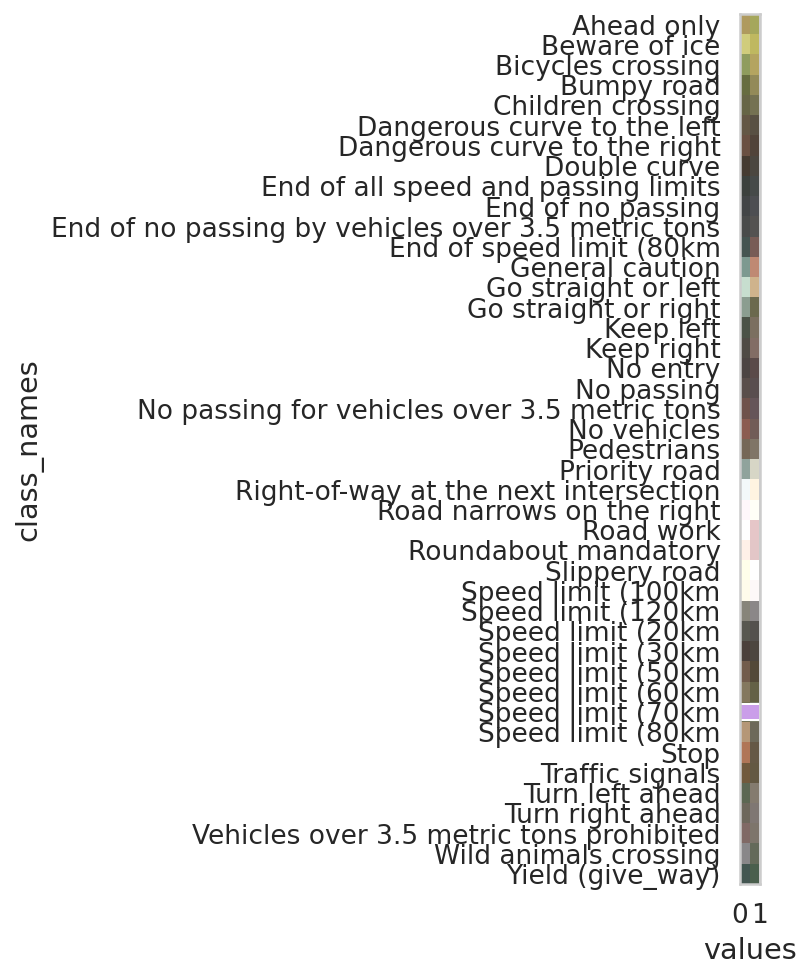

In [ ]:

#show_image('GTSRB/Final_Test/Images/00000.ppm')

#pred = predict_proba(base_model, 'stop-sign.jpg')


import cv2
import matplotlib.pyplot as plt
img = cv2.imread("GTSRB/Final_Test/Images/04781.ppm")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
show_image(img)
print()
pred_temp = predict_proba(base_model, 'GTSRB/Final_Test/Images/04781.ppm')
show_prediction_confidence(pred_temp, class_names)

##FPS 2

In [ ]:
# Few imports

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import time
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


!rm -rd GTSRB_Final_Test_Images.zip
!rm -rf GTSRB/Final_Test
!rm -rf GTSRB/Readme-Images-Final-test.txt
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Test_Images.zip
!unzip -qq GTSRB_Final_Test_Images.zip
#!mv GTSRB/Final_Test/ data/

!rm -rd GTSRB_Final_Test_GT.zip
!rm -rf GT-final_test.csv
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Test_GT.zip
!unzip -qq GTSRB_Final_Test_GT.zip
#!mv GT-final_test.csv data/Final_Test/Images/

# Define transformations

test_transforms = transforms.Compose([
    transforms.Resize(size=256),
    transforms.ToTensor(),
    transforms.Normalize(mean_nums, std_nums)
    ])

# Define path of test data

test_data_path = 'GTSRB/Final_Test'
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)
test_loader = data.DataLoader(test_data, batch_size=1, shuffle=False)

# Define hyperparameters

numClasses = 43

# Generating labels of classes

num = range(numClasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])
print("List of labels : ")
print("Actual labels \t--> Class in PyTorch")
for i in num:
    print("\t%d \t--> \t%d" % (labels[i], i))

    # Read the image labels from the csv file
# Note: The labels provided are all numbers, whereas the labels assigned by PyTorch dataloader are strings

df = pd.read_csv('GT-final_test.csv')
numExamples = len(df)
#labels_list = list(df.ClassId)
df = df.iloc[1: , :] #drop prima riga
labels_list = df.iloc[:,-1:] # prendi ultima colonna


base_model = create_model("resnet18",len(class_names))
base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18.pt', map_location = device))     

#model = base_model.toDevice()
model=base_model


rm: cannot remove 'GTSRB_Final_Test_Images.zip': No such file or directory
--2022-07-11 21:18:17--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-11 21:18:18 ERROR 404: Not Found.

unzip:  cannot find or open GTSRB_Final_Test_Images.zip, GTSRB_Final_Test_Images.zip.zip or GTSRB_Final_Test_Images.zip.ZIP.
rm: cannot remove 'GTSRB_Final_Test_GT.zip': No such file or directory
--2022-07-11 21:18:19--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-11 21:18:19 ERROR 404: Not Found.

unzip:  cannot find or open GTSRB_Final_Test_GT.zip

FileNotFoundError: ignored

In [ ]:
# Perform classification

y_pred_list = []
corr_classified = 0

with torch.no_grad():
    model.eval()

    i = 0

    for image, _ in test_loader:
        image = image.cuda()

        y_test_pred = model(image)

        y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
        y_pred_tags = y_pred_tags.cpu().numpy()
        
        y_pred = y_pred_tags[0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)

        if labels_list[i] == y_pred:
            corr_classified += 1

        i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

IndexError: ignored

##Final Test